In [12]:
!pip install openpyxl
!pip install pgeocode plotly


In [13]:
import duckdb
import pandas as pd
import openpyxl
import pgeocode
import plotly.express as px

In [31]:

# Load your claims data into a DataFrame from Excel
claims_df = pd.read_excel(r'Case Study 1 - Sample Claims.xlsx', sheet_name= 1)

# Connect to DuckDB (in-memory)
con = duckdb.connect()

# Register the DataFrame as a table
con.register('claims', claims_df)

# Use a CTE to find NSCLC patients and their locations
result = con.execute("""
    WITH nsclc_patients AS (
        SELECT PATIENT_ID, CLAIM_BEST_ZIP
        FROM claims
        WHERE DIAG1_CD LIKE 'C34%'
           OR DIAG2_CD LIKE 'C34%'
           OR DIAG3_CD LIKE 'C34%'
           OR DIAG4_CD LIKE 'C34%'
           OR DIAG5_CD LIKE 'C34%'
           OR DIAG6_CD LIKE 'C34%'
           OR DIAG7_CD LIKE 'C34%'
           OR DIAG8_CD LIKE 'C34%'
    )
    SELECT COUNT(DISTINCT PATIENT_ID) AS num_nsclc_patients,
           ARRAY_AGG(DISTINCT CLAIM_BEST_ZIP) AS zip_codes
    FROM nsclc_patients
""").fetchdf()

print(result)


   num_nsclc_patients                                          zip_codes
0               12332  [48201, 48360, 77030, 55415, 33613, 78229, 309...


In [32]:
# Extract ZIP codes from the result DataFrame
zip_codes = result.at[0, 'zip_codes']

# Create a DataFrame for ZIP codes (assuming each ZIP has at least one patient)
zip_df = pd.DataFrame({'CLAIM_BEST_ZIP': zip_codes, 'count': 1})


In [33]:
# Ensure ZIP codes are strings and drop missing values
zip_df = zip_df.dropna(subset=['CLAIM_BEST_ZIP'])
zip_df['CLAIM_BEST_ZIP'] = zip_df['CLAIM_BEST_ZIP'].astype(str)

# Now run the geocoding
geo_info = nomi.query_postal_code(zip_df['CLAIM_BEST_ZIP'].tolist())

# Assign latitude and longitude as before
zip_df['latitude'] = geo_info['latitude']
zip_df['longitude'] = geo_info['longitude']

# Remove rows with missing coordinates
zip_df = zip_df.dropna(subset=['latitude', 'longitude'])


In [34]:

fig = px.scatter_mapbox(
    zip_df,
    lat='latitude',
    lon='longitude',
    size='count',  # All are 1 unless you have counts per ZIP
    hover_name='CLAIM_BEST_ZIP',
    color='count',
    color_continuous_scale='Viridis',
    size_max=15,
    zoom=4,
    mapbox_style='open-street-map',
    title='NSCLC Patients by ZIP Code'
)
fig.show()


C:\Users\sahal\AppData\Local\Temp\ipykernel_18772\2132705737.py:1: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [35]:

fig = px.scatter_map(
    zip_df,
    lat='latitude',
    lon='longitude',
    size='count',  # Use actual patient counts per ZIP
    hover_name='CLAIM_BEST_ZIP',
    color='count',
    color_continuous_scale='Viridis',
    size_max=15,
    zoom=4,
    title='NSCLC Patients by ZIP Code'
)
fig.show()


In [52]:
nsclc_patients = con.execute("""
    SELECT PATIENT_ID, CLAIM_BEST_ZIP
    FROM claims
    WHERE DIAG1_CD LIKE 'C34%'
       OR DIAG2_CD LIKE 'C34%'
       OR DIAG3_CD LIKE 'C34%'
       OR DIAG4_CD LIKE 'C34%'
       OR DIAG5_CD LIKE 'C34%'
       OR DIAG6_CD LIKE 'C34%'
       OR DIAG7_CD LIKE 'C34%'
       OR DIAG8_CD LIKE 'C34%'
""").fetchdf()


In [51]:
con.execute("""SELECT DISTINCT PATIENT_ID, CLAIM_BEST_ZIP
FROM claims
WHERE 'C34%' LIKE ANY (ARRAY[
  DIAG1_CD, DIAG2_CD, DIAG3_CD, DIAG4_CD,
  DIAG5_CD, DIAG6_CD, DIAG7_CD, DIAG8_CD
])
""").fetchdf()          


ParserException: Parser Error: Unsupported comparison "~~" for ANY/ALL subquery

In [47]:
zip_counts = nsclc_patients['CLAIM_BEST_ZIP'].value_counts().reset_index()
zip_counts.columns = ['CLAIM_BEST_ZIP', 'count']

print(zip_counts)


      CLAIM_BEST_ZIP  count
0              91010    387
1              33612    373
2              10065    283
3              46202    245
4              44195    242
...              ...    ...
3573           70508      1
3574           36330      1
3575           19022      1
3576           84041      1
3577           92618      1

[3578 rows x 2 columns]


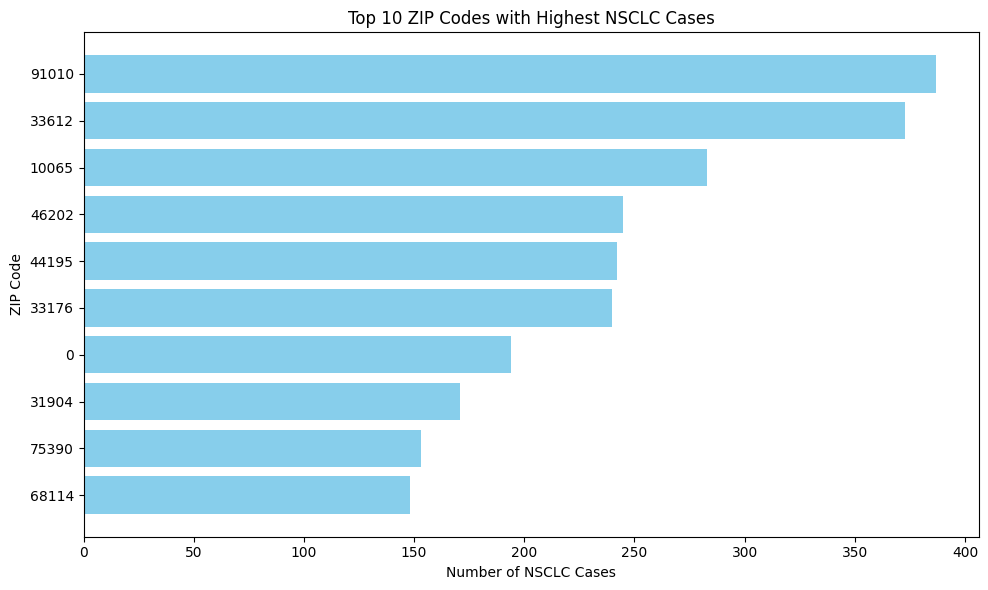

In [48]:
import matplotlib.pyplot as plt

top_zip_counts = zip_counts.nlargest(10, 'count')

plt.figure(figsize=(10, 6))
plt.barh(top_zip_counts['CLAIM_BEST_ZIP'].astype(str), top_zip_counts['count'], color='skyblue')
plt.xlabel('Number of NSCLC Cases')
plt.ylabel('ZIP Code')
plt.title('Top 10 ZIP Codes with Highest NSCLC Cases')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
# Convert both columns to string type before merging
zip_countss['CLAIM_BEST_ZIP'] = zip_counts['CLAIM_BEST_ZIP'].astype(str)
zip_df['CLAIM_BEST_ZIP'] = zip_df['CLAIM_BEST_ZIP'].astype(str)

# Now merge
plot_dff = pd.concat(zip_counts, zip_df, on='CLAIM_BEST_ZIP', how='inner')


ValueError: You are trying to merge on int64 and object columns for key 'CLAIM_BEST_ZIP'. If you wish to proceed you should use pd.concat

In [ ]:
plot_dff = pd.merge(zip_counts, zip_df, on='CLAIM_BEST_ZIP', how='inner')


ValueError: You are trying to merge on int64 and object columns for key 'CLAIM_BEST_ZIP'. If you wish to proceed you should use pd.concat